In [1]:
#import libraries 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
#set path 
path = r'/Users/yanggao/Desktop/DAbootcamp/Python_Fundamentals_for_Data_Analysts_Achievement_4/Instacart_Basket_Analysis'

In [3]:
#import dataframe
ords_prods_customer_merge = pd.read_pickle(os.path.join(path, '02_Data', 'Prepared_data', 'ords_prods_customer_merge.pkl'))

In [4]:
#2 ANY PII data security issue need to be addressed?

In [5]:
ords_prods_customer_merge.columns

Index(['order_id', 'customer_id', 'order_number', 'order_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', '_merge', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest_day',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_price',
       'Spending_flag', 'median_order_duration', 'frequency_flag',
       'first_name', 'last_name', 'gender', 'state', 'age', 'date_joined',
       'num_of_dependants', 'marital_status', 'income'],
      dtype='object')

In [6]:
#2 answer: I dont think there should be any data securtiy issues here, since we don't have any sensitive private information like SSN and birthday

In [7]:
#3 customer behavior in different geographic areas

In [8]:
#3a. created different regions based on the Wiki article
Northeast=['Maine','New Hampshire','Vermont','Massachusetts','Rhode Island','Connecticut','New York','Pennsylvania'
        ,'New Jersey']
Midwest=['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota','South Dakota','Nebraska','Kansas'
         ,'Minnesota','Iowa','Missouri']
South=['Delaware','Maryland','District of Columbia','Virginia','West Virginia','North Carolina','South Carolina'
       ,'Georgia','Florida','Kentucky','Tennessee','Mississippi','Alabama','Oklahoma','Texas','Arkansas','Louisiana']
West=['Idaho','Montana','Wyoming','Nevada','Utah','Colorado','Arizona','New Mexico','Alaska','Washington','Oregon',
      'California','Hawaii']

In [9]:
ords_prods_customer_merge.loc[ords_prods_customer_merge['state'].isin(Northeast), 'region']='Northeaset'
ords_prods_customer_merge.loc[ords_prods_customer_merge['state'].isin(Midwest), 'region']='Midwest'
ords_prods_customer_merge.loc[ords_prods_customer_merge['state'].isin(South), 'region']='South'
ords_prods_customer_merge.loc[ords_prods_customer_merge['state'].isin(West), 'region']='West'

In [10]:
#frequency check 
ords_prods_customer_merge['region'].value_counts(dropna=False)

South         10791885
West           8292913
Midwest        7597325
Northeaset     5722736
Name: region, dtype: int64

In [11]:
#3b spending habits between the different U.S. regions using crosstab
crosstab_spending_region = pd.crosstab(ords_prods_customer_merge['region'], ords_prods_customer_merge['Spending_flag'], dropna = False)
crosstab_spending_region

Spending_flag,High Spender,Low Spender
region,,
Midwest,155975,7441350
Northeaset,108225,5614511
South,209691,10582194
West,160354,8132559


In [12]:
# every regions has much more low spenders than high spenders

In [13]:
##Merge dataframe with Department info
#import department df 
df_department=pd.read_csv(os.path.join(path, '02_Data', 'Prepared_data', 'department_checked.csv'), index_col= False)

In [14]:
df_department.head()

,Unnamed: 0,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [16]:
#rename 
df_department.rename(columns={'Unnamed: 0':'department_id'}, inplace=True)

In [18]:
#merge two df with "department_id"
df_merged = ords_prods_customer_merge.merge(df_department, on ='department_id')

In [19]:
df_merged.columns

Index(['order_id', 'customer_id', 'order_number', 'order_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', '_merge', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest_day',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_price',
       'Spending_flag', 'median_order_duration', 'frequency_flag',
       'first_name', 'last_name', 'gender', 'state', 'age', 'date_joined',
       'num_of_dependants', 'marital_status', 'income', 'region',
       'department'],
      dtype='object')

In [20]:
df_merged.shape

(32404859, 34)

In [22]:
#4 Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data
# Create activity flag and frequency check 
df_merged.loc[df_merged['max_order']>=5, 'activity']='high'
df_merged.loc[df_merged['max_order']<5, 'activity']='low'
df_merged['activity'].value_counts(dropna=False)

high    30964564
low      1440295
Name: activity, dtype: int64

In [24]:
#create inactive_customer df
inactive_customer = df_merged[df_merged['activity']=='low']

In [25]:
inactive_customer['activity'].value_counts(dropna=False)

low    1440295
Name: activity, dtype: int64

In [27]:
#export inactive_customer df
inactive_customer.to_pickle(os.path.join(path, '02_Data', 'Prepared_data', 'inactive_customer.pkl'))

In [28]:
#create active_customer df
active_customer = df_merged[df_merged['activity']=='high']

In [29]:
active_customer['activity'].value_counts(dropna=False)

high    30964564
Name: activity, dtype: int64

In [30]:
#del pervious df for memory usage, and only using active_customer df from now on
del inactive_customer
del df_merged
del ords_prods_customer_merge

In [31]:
#5 Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents

In [32]:
#5a age profiling and frequency check 
active_customer.loc[active_customer['age']<=35, 'age_group']= 'young'
active_customer.loc[active_customer['age']>55, 'age_group']= 'older'
active_customer.loc[(active_customer['age']>35) & (active_customer['age']<=55), 'age_group']= 'middle'
active_customer['age_group'].value_counts(dropna=False)

older     12508298
middle     9717461
young      8738805
Name: age_group, dtype: int64

In [34]:
#5b income profiling and frequency check, based on google, low income is consider income < $54,000 per year in US, and high income is cosidered >$107,000 per year
active_customer.loc[active_customer['income']<54000, 'income_group']= 'low income'
active_customer.loc[active_customer['income']>=107000, 'income_group']= 'high income'
active_customer.loc[(active_customer['income']>=54000) & (active_customer['income']<107000), 'income_group']= 'middle income'
active_customer['income_group'].value_counts(dropna=False)

middle income    14470856
high income      12304528
low income        4189180
Name: income_group, dtype: int64

In [35]:
#5c dependants profiling 
active_customer.loc[active_customer['num_of_dependants']>0, 'dependant_group']= 'has dependants'
active_customer.loc[active_customer['num_of_dependants']==0, 'dependant_group']= 'no dependants'
active_customer['dependant_group'].value_counts(dropna=False)

has dependants    23224883
no dependants      7739681
Name: dependant_group, dtype: int64

In [36]:
#certain food in the department profiling 
active_customer['department'].value_counts(dropna=False)

produce            9079273
dairy eggs         5177182
snacks             2766406
beverages          2571901
frozen             2121731
pantry             1782705
bakery             1120828
canned goods       1012074
deli               1003834
dry goods pasta     822136
household           699857
meat seafood        674781
breakfast           670850
personal care       424306
babies              410392
international       255991
alcohol             144627
pets                 93060
missing              64768
other                34411
bulk                 33451
Name: department, dtype: int64

In [42]:
#Creating flags for bought baby stuff(1)/didn't buy baby stuff (0)
active_customer['baby_status'] = [1 if x == 'babies' else 0 for x in active_customer['department']]
active_customer['baby_status']=active_customer.groupby(['customer_id'])['baby_status'].transform(np.max)
active_customer['baby_status'].value_counts(dropna=False)

0    21154311
1     9810253
Name: baby_status, dtype: int64

In [43]:
#Creating flag for: has a pet(1)/doesn't have pets(0).
active_customer['pet_status']=[1 if x=='pets' else 0 for x in active_customer['department']]
active_customer['pet_status']=active_customer.groupby(['customer_id'])['pet_status'].transform(np.max)
active_customer['pet_status'].value_counts(dropna=False)

0    27513213
1     3451351
Name: pet_status, dtype: int64

In [45]:
#Creating a flag for: alcohol drinker(1)/not drinker(0).
active_customer['alcohol_status']=[1 if x=='alcohol' else 0 for x in active_customer['department']]
active_customer['alcohol_status']=active_customer.groupby(['customer_id'])['alcohol_status'].transform(np.max)
active_customer['alcohol_status'].value_counts(dropna=False)

0    28634074
1     2330490
Name: alcohol_status, dtype: int64

In [46]:
active_customer.columns

Index(['order_id', 'customer_id', 'order_number', 'order_day_of_week',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', '_merge', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest_day',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_price',
       'Spending_flag', 'median_order_duration', 'frequency_flag',
       'first_name', 'last_name', 'gender', 'state', 'age', 'date_joined',
       'num_of_dependants', 'marital_status', 'income', 'region', 'department',
       'activity', 'age_group', 'income_group', 'dependant_group',
       'baby_status', 'pet_status', 'alcohol_status'],
      dtype='object')

In [47]:
#export dataframe
active_customer.to_pickle(os.path.join(path, '02_Data', 'Prepared_data', 'active_customer.pkl'))

In [48]:
#6 Create appropriate visulization 

In [55]:
#set a subset of unique customer 
unique_customer = active_customer.drop_duplicates(subset=['customer_id'])

In [54]:
unique_customer.shape

(162631, 41)

Text(0, 0.5, 'number of customers')

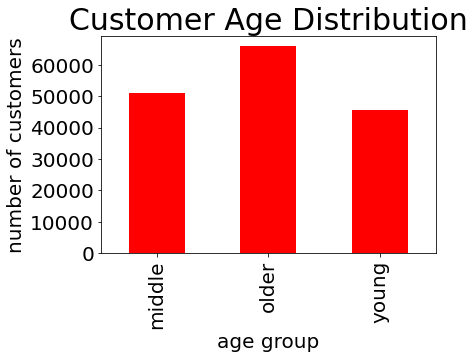

In [58]:
#6a create a bar chart for age distribution 
bar_aging = unique_customer['age_group'].value_counts().sort_index().plot.bar(color = '#FF0000', fontsize=20)
plt.title('Customer Age Distribution', fontsize=30)
plt.xlabel('age group', fontsize=20)
plt.ylabel('number of customers', fontsize=20)

Text(0, 0.5, 'number of customers')

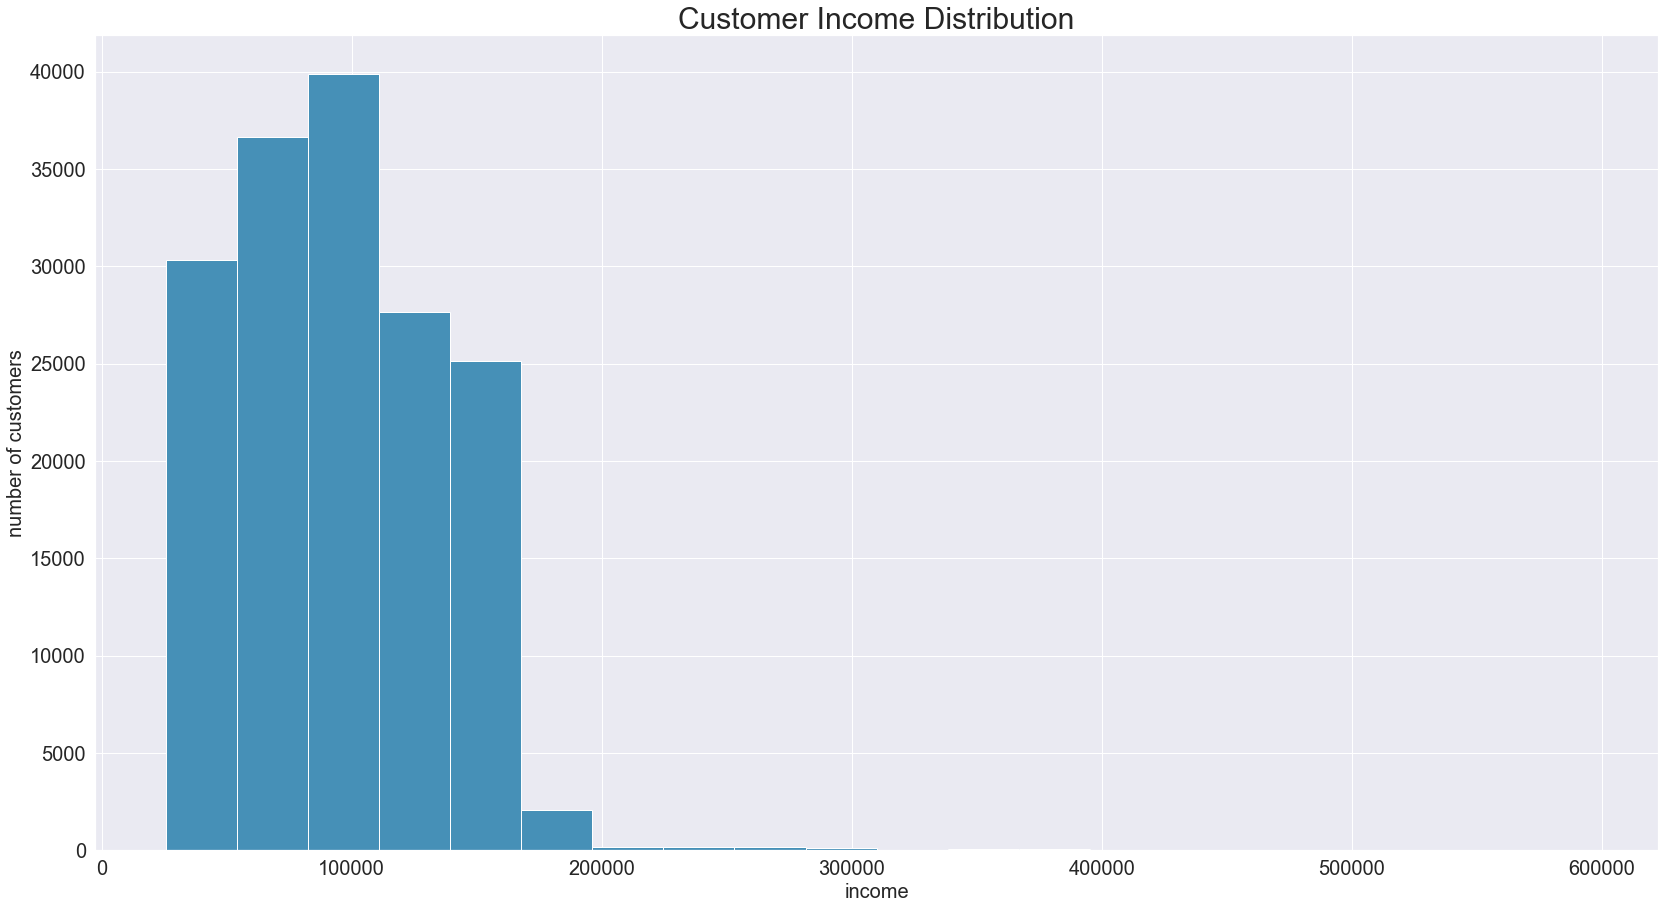

In [68]:
#6b create a histogram of customers income
sns.set(rc = {'figure.figsize':(28,15)})
hist_income = unique_customer['income'].plot.hist(bins=20, color='#4690b7', fontsize = 20)
plt.title('Customer Income Distribution', fontsize=30)
plt.xlabel('income', fontsize=20)
plt.ylabel('number of customers', fontsize=20)

In [69]:
#6c dependants profiling
#create a crosstab for dependants and marital_status
dependant_crosstab = pd.crosstab(unique_customer['marital_status'], unique_customer['dependant_group'])
dependant_crosstab

dependant_group,has dependants,no dependants
marital_status,,
divorced/widowed,0,13831
living with parents and siblings,7608,0
married,114296,0
single,0,26896


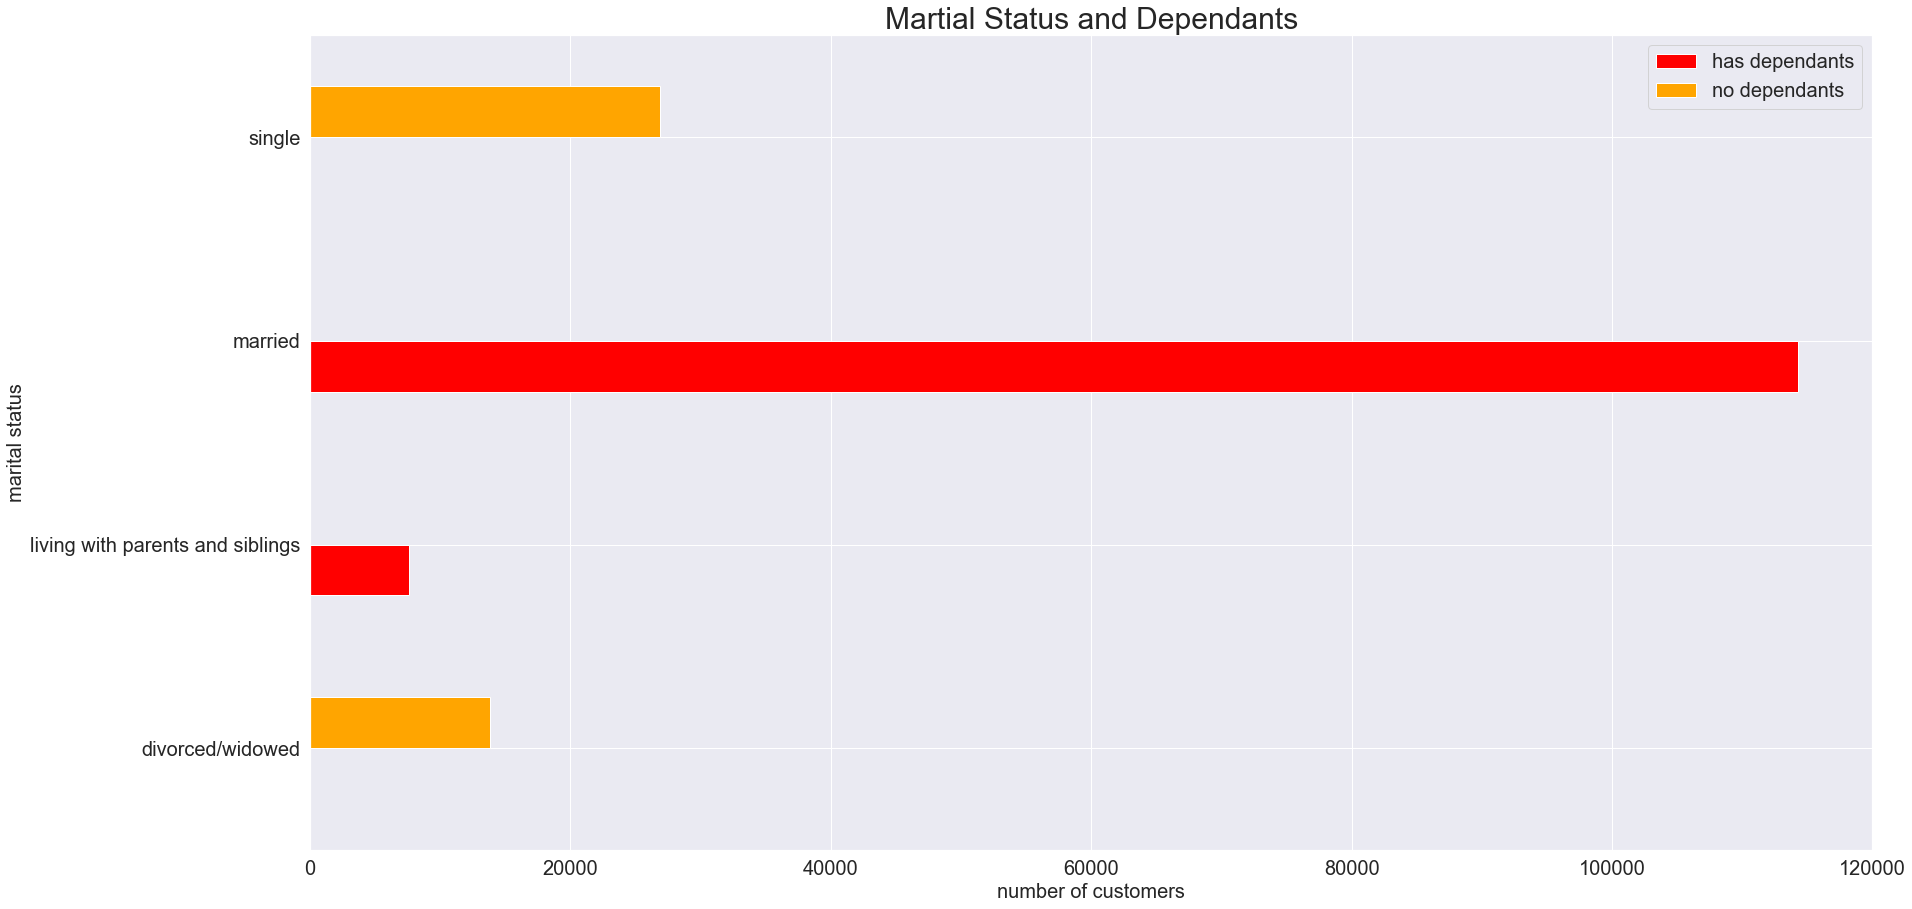

In [71]:
#create a bar chart for the crosstab
bar_dependant_crosstab = dependant_crosstab.plot.barh(color=['red','orange'], fontsize = 20)
plt.title('Martial Status and Dependants', fontsize=30)
plt.xlabel('number of customers', fontsize=20)
plt.ylabel('marital status', fontsize=20)
plt.legend(fontsize=20)

In [72]:
#6d baby stuff 
#create a crosstab for baby stuff and marital_status
babystuff_crosstab = pd.crosstab(unique_customer['marital_status'], unique_customer['baby_status'])
babystuff_crosstab

baby_status,0,1
marital_status,,
divorced/widowed,11209,2622
living with parents and siblings,6204,1404
married,93047,21249
single,21941,4955


In [73]:
#we can see from the crosstab that people buys baby stuff disregrad their marital status, so we can infer that people will buy baby stuff (maybe as a gift) even their dont have kids

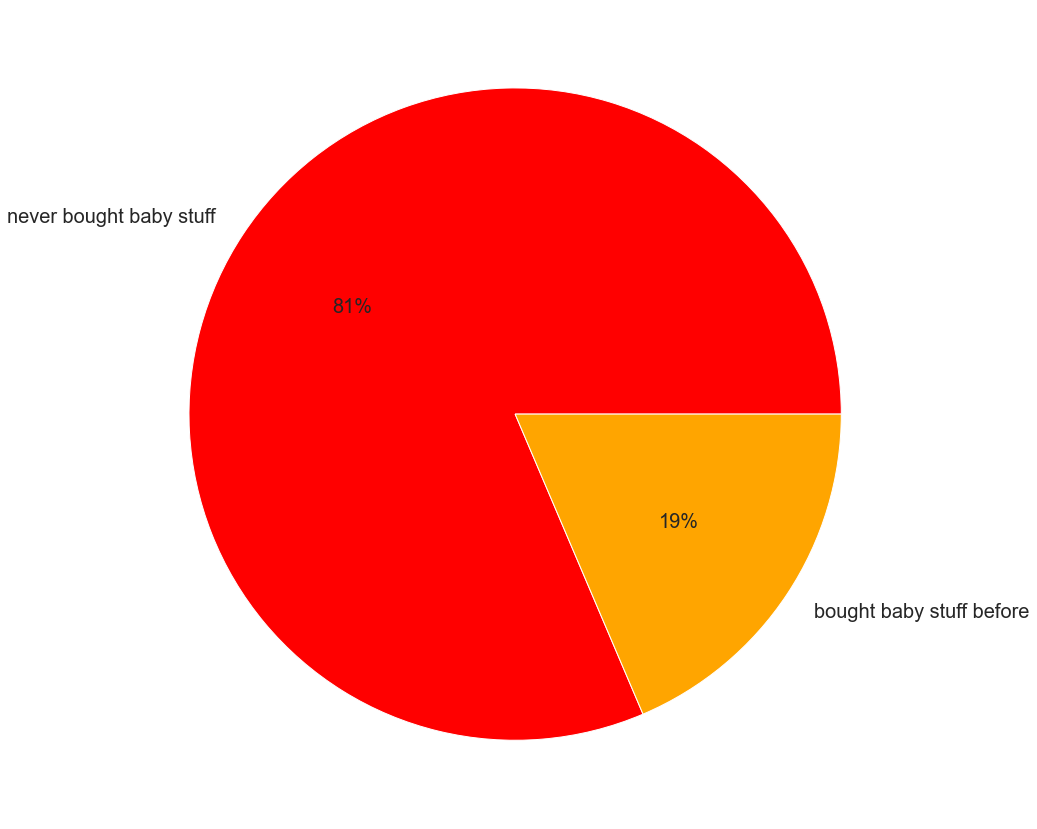

In [74]:
#create a pie chart for the customer who brought baby stuff and for those who did not buy baby stuff
pie_baby = unique_customer['baby_status'].value_counts().plot.pie(label='', labels=['never bought baby stuff', 'bought baby stuff before'],autopct=('%1.f%%'), colors=['red','orange'], textprops={'fontsize': 20})

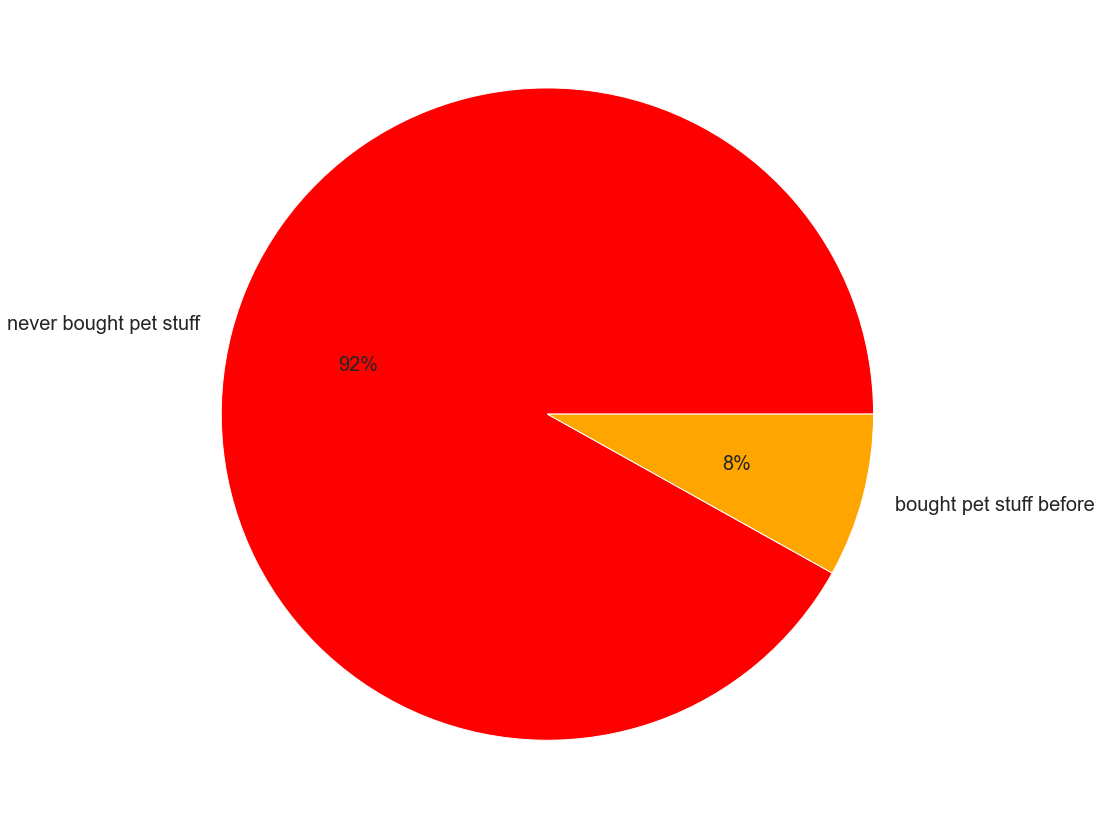

In [75]:
#create a pie chart for the customer who brought pet stuff and for those who did not buy pet stuff
pie_pet = unique_customer['pet_status'].value_counts().plot.pie(label='', labels=['never bought pet stuff', 'bought pet stuff before'],autopct=('%1.f%%'), colors=['red','orange'], textprops={'fontsize': 20})

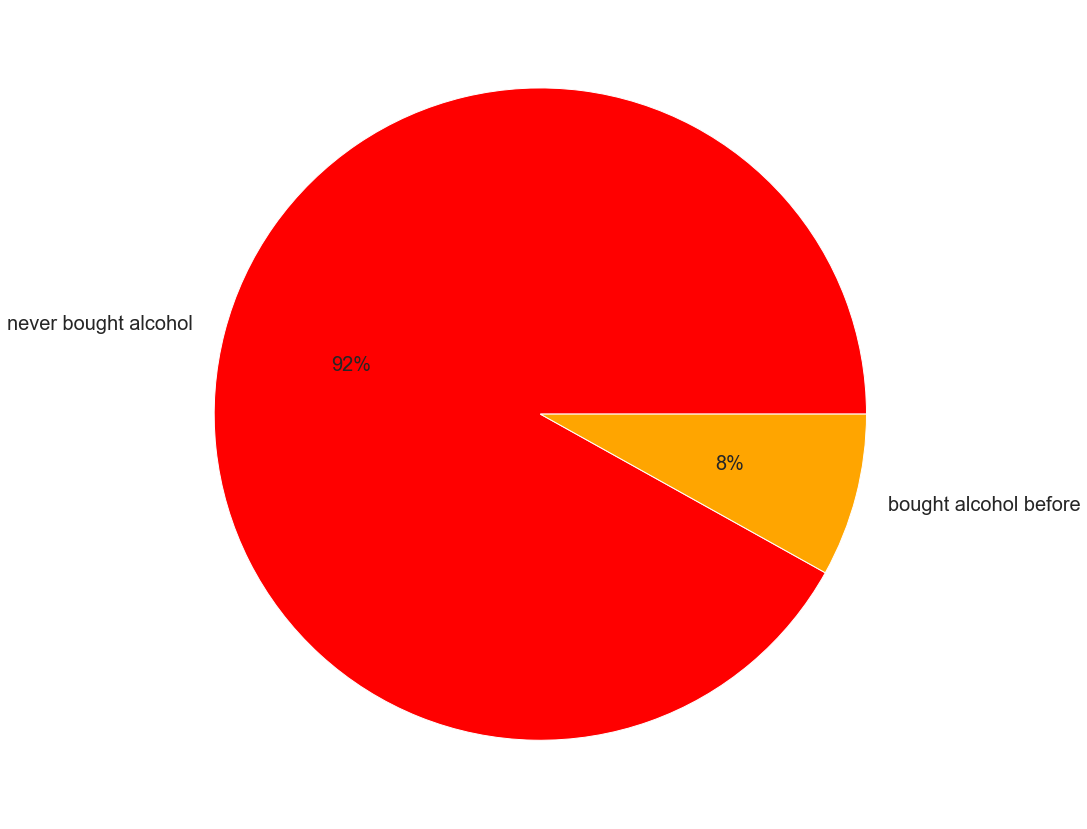

In [76]:
#create a pie chart for the customer who brought alcohol and for those who did not buy alcohol
pie_alcohol = unique_customer['alcohol_status'].value_counts().plot.pie(label='', labels=['never bought alcohol', 'bought alcohol before'],autopct=('%1.f%%'), colors=['red','orange'], textprops={'fontsize': 20})

In [77]:
#7 Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [80]:
#7a age aggregation
unique_customer.groupby(['age_group']).agg({'median_order_duration':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

median_order_duration               prices           
                           mean  min   max      mean  min   max
age_group                                                      
middle                13.757527  0.0  30.0  7.638671  1.0  15.0
older                 13.755983  0.0  30.0  7.610490  1.0  19.4
young                 13.781753  0.0  30.0  7.612501  1.0  15.0

In [81]:
#7b income aggregation
unique_customer.groupby(['income_group']).agg({'median_order_duration':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

median_order_duration               prices           
                               mean  min   max      mean  min   max
income_group                                                       
high income               13.534094  0.0  30.0  7.787977  1.0  19.4
low income                14.602374  0.0  30.0  6.936526  1.0  15.0
middle income             13.609492  0.0  30.0  7.761605  1.0  15.0

In [82]:
#7c dependant group aggregation 
unique_customer.groupby(['dependant_group']).agg({'median_order_duration':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

median_order_duration               prices           
                                 mean  min   max      mean  min   max
dependant_group                                                      
has dependants              13.762157  0.0  30.0  7.624134  1.0  19.4
no dependants               13.768348  0.0  30.0  7.607230  1.0  15.0

In [83]:
#7d baby stuff aggregation, baby status 0 = didn't buy baby, baby status 1= bought baby stuff
unique_customer.groupby(['baby_status']).agg({'median_order_duration':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

median_order_duration               prices           
                             mean  min   max      mean  min   max
baby_status                                                      
0                       14.314280  0.0  30.0  7.621146  1.0  19.4
1                       11.352316  0.0  30.0  7.614446  1.0  15.0

In [85]:
#7e pet stuff aggregation, pet status 0 = didn't buy pet stuff, pet status 1= bought pet stuff
unique_customer.groupby(['pet_status']).agg({'median_order_duration':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

median_order_duration               prices           
                            mean  min   max      mean  min   max
pet_status                                                      
0                      13.882330  0.0  30.0  7.608304  1.0  19.4
1                      12.418065  0.0  30.0  7.751461  1.0  15.0

In [86]:
#7f alcohol aggregation,alcohol status 0 = didn't buy alcohol, alcohol status 1= bought alcohol
unique_customer.groupby(['alcohol_status']).agg({'median_order_duration':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

median_order_duration               prices           
                                mean  min   max      mean  min   max
alcohol_status                                                      
0                          13.838614  0.0  30.0  7.616542  1.0  19.4
1                          12.912288  0.0  30.0  7.658098  1.0  15.0

In [90]:
#customer profiles with regions and departments
region_department_crosstab = pd.crosstab(unique_customer['region'], unique_customer['department'])
region_department_crosstab

department,alcohol,babies,bakery,beverages,breakfast,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,pantry,personal care,produce,snacks
region,,,,,,,,,,,,,,,,,
Midwest,7,0,4,33745,2,0,4025,2,0,6,86,1,0,10,2,154,332
Northeaset,4,1,3,25076,3,0,3035,1,0,10,55,0,0,8,0,136,249
South,12,0,1,47561,4,1,5750,1,1,13,114,1,0,11,1,257,465
West,4,0,3,36359,2,0,4444,2,0,7,93,0,1,7,1,181,377


In [93]:
#answer 8: Customers demonstrate similar behaviors across regions

In [94]:
#export unique customer dataframe
unique_customer.to_pickle(os.path.join(path, '02_Data', 'Prepared_data', 'unique_customer.pkl'))

In [95]:
#export chart 
bar_aging.figure.savefig(os.path.join(path, '04_Analysis', 'Visualizations', 'bar_aging_10.png'))

In [96]:
hist_income.figure.savefig(os.path.join(path, '04_Analysis', 'Visualizations', 'hist_income_10.png'))

In [97]:
bar_dependant_crosstab.figure.savefig(os.path.join(path, '04_Analysis', 'Visualizations', 'dependant_crosstab.png'))

In [98]:
pie_babypie_petpie_pet

In [ ]:
pie_pet